In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import torchvision.transforms as T
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Image To Patches


In [2]:
image = Image.open("car.png").resize((224, 224))
x = np.array(image)

P = 16  # patch_size
C = 3

# split image into patches
patches = (
    x.reshape(x.shape[0] // P, P, x.shape[1] // P, P, C)
    .swapaxes(1, 2)
    .reshape(-1, P, P, C)
)

# flatten patches
x_p = np.reshape(patches, (-1, P * P * C))

# get number of patches
N = x_p.shape[0]

print("Image shape: ", x.shape)  # width, height, channel
print("Number of patches: {} with resolution ({}, {})".format(N, P, P))
print("Patches shape: ", patches.shape)
print("Flattened patches shape: ", x_p.shape)

Image shape:  (224, 224, 3)
Number of patches: 196 with resolution (16, 16)
Patches shape:  (196, 16, 16, 3)
Flattened patches shape:  (196, 768)


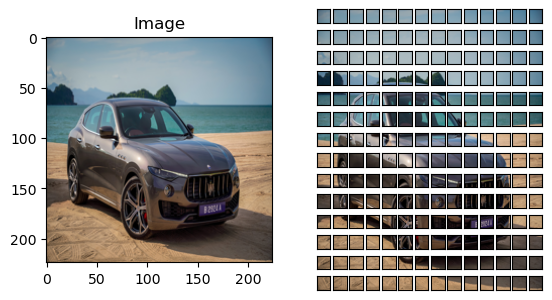

In [3]:
# visualize data
#
# display image and patches side-by-side

fig = plt.figure()

gridspec = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gridspec[0])
ax1.set(title="Image")

# display image
ax1.imshow(x)

subgridspec = gridspec[1].subgridspec(14, 14, hspace=-0.8)

# display patches
for i in range(14):  # N = 64, 8x8 grid
    for j in range(14):
        num = i * 14 + j
        ax = fig.add_subplot(subgridspec[i, j])
        ax.set(xticks=[], yticks=[])
        ax.imshow(patches[num])

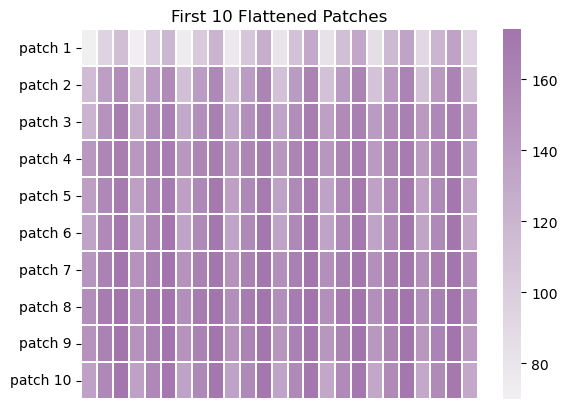

In [4]:
# visualize data
#
# display flattened patches

# display first 10 flattened patches up to 25 values
heat_map = x_p[:10, :25]

yticklabels = ["patch " + str(i + 1) for i in range(10)]

plt.title("First 10 Flattened Patches")
ax = sns.heatmap(
    heat_map,
    cmap=sns.light_palette("#a275ac", as_cmap=True),
    xticklabels=False,
    yticklabels=yticklabels,
    linewidths=0.01,
    linecolor="white",
)

In [5]:
class PatchEmbedding(nn.Module):
    def __init__(
        self, image_size=224, patch_size=16, num_channels=3, embedding_size=768
    ) -> None:
        super().__init__()
        self.num_patches = (image_size // patch_size) ** 2
        self.projection = nn.Conv2d(
            num_channels,
            embedding_size,
            kernel_size=patch_size,
            stride=patch_size,
        )

    def forward(self, x: Tensor) -> Tensor:
        x = self.projection(x)
        x = torch.flatten(x, start_dim=2).transpose(1, 2)
        return x

In [6]:
x = x.transpose(2, 0, 1)
# add batch_size
x = np.expand_dims(x, axis=0)
print(x.shape)
x = torch.from_numpy(x).to(torch.float32)

(1, 3, 224, 224)


In [7]:
patch_embedding = PatchEmbedding()
out = patch_embedding(x)
print(out.shape)

torch.Size([1, 196, 768])


# Embedding Patches


In [8]:
# dimensionality of patch embeddings
embedding_size = 768

# Batch size
B = 1
x_p = Tensor(x_p)

# add batch dimention
x_p = x_p[None, ...]

# weight matrix E
E = nn.Parameter(torch.randn(1, P * P * C, embedding_size))
patch_embeddings = torch.matmul(x_p, E)
print(patch_embeddings.shape)

torch.Size([1, 196, 768])


# Class Token (CLS Token)


In [9]:
class_token = nn.Parameter(torch.randn(1, 1, embedding_size))

patch_embeddings = torch.cat((class_token, patch_embeddings), 1)

print(patch_embeddings.shape)

torch.Size([1, 197, 768])


In [10]:
class Embeddings(nn.Module):
    def __init__(
        self,
        image_size=224,
        patch_size=16,
        num_channels=3,
        embedding_size=768,
        dropout=0.3,
    ) -> None:
        super().__init__()
        self.patch_embedding = PatchEmbedding(
            image_size=image_size,
            patch_size=patch_size,
            num_channels=num_channels,
            embedding_size=embedding_size,
        )
        self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_size))
        self.position_embedding = nn.Parameter(
            torch.randn(1, self.patch_embedding.num_patches + 1, embedding_size)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: Tensor) -> Tensor:
        x = self.patch_embedding(x)
        batch_size, _, _ = x.size()
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.position_embedding
        x = self.dropout(x)
        return x

In [11]:
embedding = Embeddings()
out = embedding(x)
out.shape

torch.Size([1, 197, 768])

# Self Attention


In [12]:
class SelfAttention(nn.Module):
    def __init__(self, embedding_dim=768, attention_head_size=64, bias=True) -> None:
        super().__init__()
        self.hidden_size = embedding_dim
        self.attention_head_size = attention_head_size
        self.query = nn.Linear(embedding_dim, attention_head_size, bias=bias)
        self.key = nn.Linear(embedding_dim, attention_head_size, bias=bias)
        self.values = nn.Linear(embedding_dim, attention_head_size, bias=bias)

    def forward(self, x: Tensor) -> Tensor:
        query = self.query(x)
        key = self.key(x)
        value = self.values(x)

        k_T = torch.transpose(key, -2, -1)
        dot_products = torch.matmul(query, k_T)
        scaled_dot_products = dot_products / np.sqrt(self.attention_head_size)
        attention_weights = F.softmax(scaled_dot_products, dim=1)
        weights_values = torch.matmul(attention_weights, value)
        return weights_values

In [13]:
attention_head_size = 64

self_attention = SelfAttention(embedding_size, attention_head_size)
attention_scores = self_attention(patch_embeddings)
print(attention_scores.shape)

torch.Size([1, 197, 64])


# Multi-Head Self-Attention


In [14]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embedding_dim=768, num_attention_heads=12, bias=True) -> None:
        super().__init__()
        self.num_heads = num_attention_heads
        self.embedding_dim = embedding_dim
        assert embedding_dim % num_attention_heads == 0
        self.attention_head_size = self.embedding_dim // num_attention_heads
        self.multi_head_attention = nn.ModuleList([])
        for _ in range(self.num_heads):
            head = SelfAttention(embedding_dim, self.attention_head_size, bias)
            self.multi_head_attention.append(head)

        self.output_projection = nn.Linear(self.attention_head_size * num_attention_heads, self.embedding_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x: Tensor) -> Tensor:
        attention_scores = [attention(x) for attention in self.multi_head_attention]
        attention_score = torch.cat(
            [attention_score for attention_score in attention_scores], dim=-1
        )
        attention_score = self.output_projection(attention_score)
        attention_score = self.dropout(attention_score)
        return attention_score

In [15]:
n_heads = 12
multi_head_attention = MultiHeadSelfAttention(embedding_size, n_heads)
print(patch_embeddings.shape)
attention_score = multi_head_attention(patch_embeddings)
print(attention_score.shape)

torch.Size([1, 197, 768])
torch.Size([1, 197, 768])


In [16]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, embedding_dim=768, hidden_dim=3072):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, embedding_dim),
        )

    def forward(self, x: Tensor) -> Tensor:
        x = self.mlp(x)
        return x

In [17]:
hidden_dim = 3072

mlp = MultiLayerPerceptron(embedding_size, hidden_dim)
output = mlp(patch_embeddings)

output.shape

torch.Size([1, 197, 768])

# Transformer Encoder

In [18]:
class TransformerEncoder(nn.Module):
    def __init__(self, embedding_dim=768, num_heads=12, hidden_dim=3072) -> None:
        super().__init__()
        self.MSA = MultiHeadSelfAttention(embedding_dim, num_heads)
        self.MLP = MultiLayerPerceptron(embedding_dim, hidden_dim)
        self.layer_norm1 = nn.LayerNorm(embedding_dim)
        self.layer_norm2 = nn.LayerNorm(embedding_dim)

    def forward(self, x: Tensor) -> Tensor:
        attention_output = self.MSA(self.layer_norm1(x))
        x = x + attention_output
        mlp_output = self.MLP(self.layer_norm2(x))
        x = x + mlp_output
        return x

In [19]:
transformer_encoder = TransformerEncoder(embedding_size, n_heads, hidden_dim)
output = transformer_encoder(patch_embeddings)
output.shape

torch.Size([1, 197, 768])

In [20]:
class Encoder(nn.Module):
    def __init__(
        self, num_layers=12, embedding_size=768, num_heads=12, hidden_dim=3072
    ) -> None:
        super().__init__()
        self.blocks = nn.ModuleList([])
        for _ in range(num_layers):
            transformer_encoder = TransformerEncoder(
                embedding_size, num_heads, hidden_dim
            )
            self.blocks.append(transformer_encoder)
    def forward(self, x: Tensor) -> Tensor:
        for block in self.blocks:
            x = block(x)
        return x

# Vision Transformer

In [21]:
class VisionTransformer(nn.Module):
    def __init__(
        self,
        patch_size=16,
        image_size=224,
        channels_size=3,
        num_layers=12,
        embedding_size=768,
        num_heads=12,
        hidden_dim=3072,
        num_classes=10,
        dropout=0.2,
    ) -> None:
        super().__init__()
        self.patch_size = patch_size
        self.channel_size = channels_size
        self.num_layers = num_layers
        self.embedding_dim = embedding_size
        self.num_heads = num_heads
        self.hidden_dim = hidden_dim
        self.dropout_prob = dropout
        self.num_classes = num_classes
        self.num_patches = int(image_size**2 / patch_size**2)

        self.embedding = Embeddings(
            image_size, patch_size, channels_size, embedding_size, dropout
        )
        self.encoder = Encoder(num_layers, embedding_size, num_heads, hidden_dim)
        self.classifier = nn.Linear(self.embedding_dim, self.num_classes)

    def forward(self, x: Tensor) -> Tensor:
        embedding_output = self.embedding(x)
        encoder_output = self.encoder(embedding_output)
        logits = self.classifier(encoder_output[:, 0, :])
        return logits

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            torch.nn.init.normal_(
                module.weight, mean=0.0, std=self.config["initializer_range"]
            )
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        elif isinstance(module, Embeddings):
            module.position_embeddings.data = nn.init.trunc_normal_(
                module.position_embeddings.data.to(torch.float32),
                mean=0.0,
                std=0.02,
            ).to(module.position_embeddings.dtype)

            module.cls_token.data = nn.init.trunc_normal_(
                module.cls_token.data.to(torch.float32),
                mean=0.0,
                std=0.02,
            ).to(module.cls_token.dtype)

In [22]:
vit = VisionTransformer()

In [23]:
output = vit(x)
output

tensor([[-1.1716,  0.6823,  0.4063, -0.1585,  2.4906,  0.6059, -0.3917,  1.3783,
         -1.2934,  1.0935]], grad_fn=<AddmmBackward0>)

In [24]:
from src.model.vit import VisionTransformer

In [25]:
vit = VisionTransformer()
output = vit(x)
output

tensor([[ 0.3301, -0.8815, -1.2201,  1.0892,  1.4679,  0.2862, -0.1297, -1.0768,
         -0.4775, -0.5704]], grad_fn=<AddmmBackward0>)